# Mining Twitter Graphs

In [37]:
import networkx as nx
from networkx.classes.function import nodes,edges, number_of_edges, number_of_nodes
from preprocessor.api import clean
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Loading dataset: State of the Union Retweet 2018
sotu_retweets = pd.read_csv('https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv')
sotu_retweets.head()

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,...,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
0,NaN,NaN,Wed Jan 31 03:51:59 +0000 2018,NaN,0,False,low,NaN,958548390052179968,958548390052179968,...,False,A PERFECT ANALOGY:\n\nSeveral democrats are br...,A PERFECT ANALOGY:\n\nSeveral democrats are br...,ScottPresler,"<a href=""http://twitter.com/download/iphone"" r...",RT @ScottPresler: A PERFECT ANALOGY:\n\nSevera...,1517370719813,False,MatthewJAld,NaN
1,NaN,NaN,Wed Jan 31 03:55:33 +0000 2018,NaN,0,False,low,NaN,958549287285215232,958549287285215232,...,False,NaN,President Trump invited families of Americans ...,RealJack,"<a href=""http://twitter.com/download/android"" ...",RT @RealJack: President Trump invited families...,1517370933730,False,broussard_sr,NaN
2,NaN,NaN,Wed Jan 31 03:09:22 +0000 2018,NaN,0,False,low,NaN,958537665334296577,958537665334296577,...,False,NaN,Don't you be fooled by any of his White Suprem...,UNITEDWEDREAM,"<a href=""http://twitter.com/download/iphone"" r...",RT @UNITEDWEDREAM: Don't you be fooled by any ...,1517368162841,False,CLSTEPHANY,NaN
3,NaN,NaN,Wed Jan 31 02:36:19 +0000 2018,NaN,0,False,low,NaN,958529347828305921,958529347828305921,...,False,NaN,Uh-oh. Our president mentioned the FIRST and S...,TomiLahren,"<a href=""http://twitter.com/download/iphone"" r...",RT @TomiLahren: Uh-oh. Our president mentioned...,1517366179793,False,DAWNSTUTESMAN,NaN
4,NaN,NaN,Wed Jan 31 02:46:24 +0000 2018,NaN,0,False,low,NaN,958531885424173057,958531885424173057,...,False,"Tonight isn't about memos, fake news, free thi...","Tonight isn't about memos, fake news, free thi...",TomiLahren,"<a href=""http://twitter.com/download/android"" ...","RT @TomiLahren: Tonight isn't about memos, fak...",1517366784803,False,SCischk,NaN


In [10]:
# Checking the columns
sotu_retweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   contributors                               0 non-null      float64
 1   coordinates                                0 non-null      float64
 2   created_at                                 2340 non-null   object 
 3   extended_entities                          283 non-null    object 
 4   favorite_count                             2340 non-null   int64  
 5   favorited                                  2340 non-null   bool   
 6   filter_level                               2340 non-null   object 
 7   geo                                        0 non-null      float64
 8   id                                         2340 non-null   int64  
 9   id_str                                     2340 non-null   int64  
 10  in_reply_to_screen_name 

In [9]:
# Filtering retweets from FoxNews
sotu_retweets_Fox = sotu_retweets[(sotu_retweets['user-screen_name'] == 'FoxNews')|
                                  (sotu_retweets['retweeted_status-user-screen_name'] == 'FoxNews')]
sotu_retweets_Fox.head()

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,...,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
52,NaN,NaN,Wed Jan 31 03:14:11 +0000 2018,NaN,0,False,low,NaN,958538876695523328,958538876695523328,...,False,".@POTUS: ""Terrorists who do things like place ...",".@POTUS: ""Terrorists who do things like place ...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""Terrorists who do thing...",1517368451652,False,coachfoster15,NaN
55,NaN,NaN,Wed Jan 31 02:52:54 +0000 2018,NaN,0,False,low,NaN,958533520988753923,958533520988753923,...,False,".@POTUS: ""For decades, open borders have allow...",".@POTUS: ""For decades, open borders have allow...",FoxNews,"<a href=""http://twitter.com/#!/download/ipad"" ...","RT @FoxNews: .@POTUS: ""For decades, open borde...",1517367174752,False,VoseJim,NaN
58,NaN,NaN,Wed Jan 31 03:06:20 +0000 2018,NaN,0,False,low,NaN,958536901211967489,958536901211967489,...,False,".@POTUS: ""We celebrate our police, our militar...",".@POTUS: ""We celebrate our police, our militar...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""We celebrate our police...",1517367980660,False,slewis8353,NaN
73,NaN,NaN,Wed Jan 31 03:16:53 +0000 2018,NaN,0,False,low,NaN,958539556155994112,958539556155994112,...,False,.@POTUS: “Let’s begin tonight by recognizing t...,.@POTUS: “Let’s begin tonight by recognizing t...,FoxNews,"<a href=""http://twitter.com/download/android"" ...",RT @FoxNews: .@POTUS: “Let’s begin tonight by ...,1517368613648,False,TravarL,NaN
84,NaN,NaN,Wed Jan 31 03:36:51 +0000 2018,NaN,0,False,low,NaN,958544581058064384,958544581058064384,...,False,".@POTUS: ""We repealed the core of disastrous #...",".@POTUS: ""We repealed the core of disastrous #...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""We repealed the core of...",1517369811678,False,kujayhawksone66,NaN


In [49]:
# How many times was FoxNews retweeted and how many times did they retweet some other user?
print(" FoxNews was retweedted {0} times".format(len(sotu_retweets_Fox[sotu_retweets_Fox['retweeted_status-user-screen_name'] == 'FoxNews'])))

print(" FoxNews retweeted {0} times".format(len(sotu_retweets_Fox[sotu_retweets_Fox['user-screen_name'] == 'FoxNews']))) 

 FoxNews was retweedted 128 times
 FoxNews retweeted 1 times


## Part A) Network Creation

 * **from_pandas_edgelist(df, source='source', target='target', edge_attr=None, create_using=None)**
     * Returns a graph from Pandas DataFrame containing an edge list.
     * The Pandas DataFrame should contain at least two columns of node names and zero or more columns of edge attributes. Each row will be processed as one edge instance.

In [27]:
# Creation of network based on FoxNews
G_rt = nx.from_pandas_edgelist(sotu_retweets_Fox, source = 'retweeted_status-user-screen_name', 
                               target = 'user-screen_name', create_using = nx.DiGraph())

In [36]:
print("# of Nodes {0}".format(number_of_nodes(G_rt))) # Users
print("# of Edges {0}".format(number_of_edges(G_rt))) # Connections

# of Nodes 130
# of Edges 129


## Part B) Network Visualization

In [41]:
# Users
nodes(G_rt)

NodeView(('FoxNews', 'coachfoster15', 'VoseJim', 'slewis8353', 'TravarL', 'kujayhawksone66', 'EblingJr', 'LaurelT1', 'SherryWhy1', 'JeSuisDog', 'LorriStringer', 'TomReed72363098', 'bobbypick', 'Texas_Trump', 'dnjma5', 'ChrisFi19702048', '2Run26', 'Lynnmorrisdown1', 'sjlev_lvgd', 'astepp37', 'jackson5213', 'GetOnTRUMPTrain', 'DeJonXIII', 'Deplorablesss', 'resterkat57', 'aburgher', 'AdvertisingLaw', 'RicoColon1', 'Karen_Becker_Go', 'SASHATAZLEA', 'stillcricket', 'Pperezz21', 'TheGhostImpala', 'lisastewart59', 'Heart4Missions', 'WEdwarda', '1Hammer', 'paphotog', 'CDFREEIII', 'jeanbadgett63', 'ProChoiceKills', 'mariadestrella', 'collm57', 'laurabennawy', 'caligurll17', 'Everloves', 'sujinhammond', 'dotpark', 'BenjiminJune1', 'travlyngirl', 'FrankieRusso1', 'trumps_feed', 'MayhewNichoel', 'brookiesamommy', 'Katjam7025', 'TinaColaco', 'Bmoreravenscm', 'SSteamroller', 'GramaD386', 'sueieque52', 'yray1', 'alres9', 'lyndamurphy1055', 'AdamBEvans', 'ENEMIESOVER', 'JuddPDeere', 'robertthedeuce', 

In [50]:
# Directed egdes = is retweeted by
edges(G_rt)

OutEdgeView([('FoxNews', 'coachfoster15'), ('FoxNews', 'VoseJim'), ('FoxNews', 'slewis8353'), ('FoxNews', 'TravarL'), ('FoxNews', 'kujayhawksone66'), ('FoxNews', 'EblingJr'), ('FoxNews', 'LaurelT1'), ('FoxNews', 'SherryWhy1'), ('FoxNews', 'JeSuisDog'), ('FoxNews', 'LorriStringer'), ('FoxNews', 'TomReed72363098'), ('FoxNews', 'bobbypick'), ('FoxNews', 'Texas_Trump'), ('FoxNews', 'dnjma5'), ('FoxNews', 'ChrisFi19702048'), ('FoxNews', '2Run26'), ('FoxNews', 'Lynnmorrisdown1'), ('FoxNews', 'sjlev_lvgd'), ('FoxNews', 'astepp37'), ('FoxNews', 'jackson5213'), ('FoxNews', 'GetOnTRUMPTrain'), ('FoxNews', 'DeJonXIII'), ('FoxNews', 'Deplorablesss'), ('FoxNews', 'resterkat57'), ('FoxNews', 'aburgher'), ('FoxNews', 'AdvertisingLaw'), ('FoxNews', 'RicoColon1'), ('FoxNews', 'Karen_Becker_Go'), ('FoxNews', 'SASHATAZLEA'), ('FoxNews', 'stillcricket'), ('FoxNews', 'Pperezz21'), ('FoxNews', 'TheGhostImpala'), ('FoxNews', 'lisastewart59'), ('FoxNews', 'Heart4Missions'), ('FoxNews', 'WEdwarda'), ('FoxNews'

In [43]:
# Degree stands for the number of edges (connections) adjacent to the node => 128 + 1 = 129
print("FoxNews degree: {0}".format(G_rt.degree('FoxNews')))

FoxNews degree: 129


* **spring_layout(G, k=None, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=None)**
    * Position nodes using Fruchterman-Reingold force-directed algorithm.
    * The algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects, sometimes called an anti-gravity force. Simulation continues until the positions are close to an equilibrium.

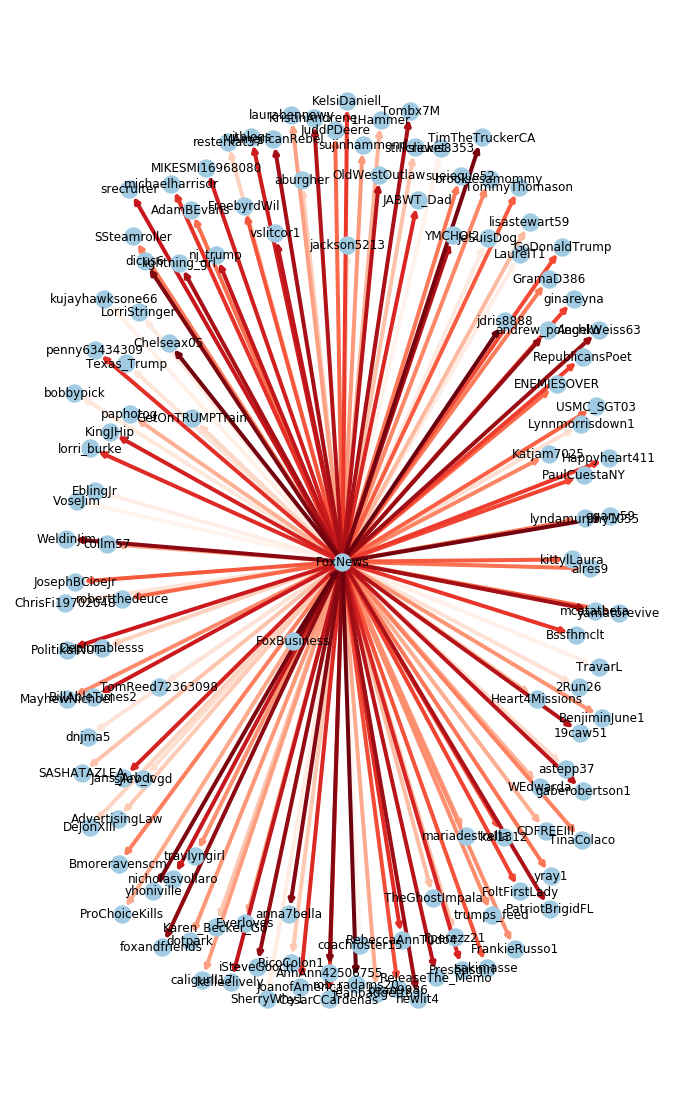

In [44]:
# Plotting the network
plt.figure(figsize=(12,20))
pos = nx.spring_layout(G_rt,k=0.20,iterations=20) # Calculates the position of the nodes

colors = range(129)

# Draws the graph based on the positions calculated previously
nx.draw_networkx(G_rt,pos,arrows=True, node_color='#A0CBE2',
                 edge_color=colors, width=4, edge_cmap=plt.cm.Reds, with_labels=True) 

plt.axis('off')
plt.show()

# Fox is the central node
# As previously discovered it only retweeted another account once >> FoxBusiness
# All the other nodes retweeted FoxNews

## Part C) Degree Centrality

In [51]:
# Creation of whole network
G_rt_full = nx.from_pandas_edgelist(sotu_retweets, source = 'retweeted_status-user-screen_name', 
                               target = 'user-screen_name', create_using = nx.DiGraph())

In [70]:
# Top 5 most retweeted users
cent_in = nx.in_degree_centrality(G_rt_full)
#print(cent_in['FoxNews'])

sorted_in = sorted(cent_in.items(), key=lambda kv: kv[1])
sorted_in[-6:-1]

[('Joeyswife', 0.0017497812773403325),
 ('cbarnella', 0.0017497812773403325),
 ('jemmtweetmaga17', 0.0017497812773403325),
 ('Forbespaula', 0.0017497812773403325),
 ('LindaGarriss', 0.0017497812773403325)]

In [71]:
# Top 5 users who retweet most
cent_out = nx.out_degree_centrality(G_rt_full)

sorted_out = sorted(cent_out.items(), key=lambda kv: kv[1])
sorted_out[-6:-1]

[('KyleKulinski', 0.01706036745406824),
 ('HouseGOP', 0.01706036745406824),
 ('TomiLahren', 0.01968503937007874),
 ('ScottPresler', 0.029746281714785654),
 ('WhiteHouse', 0.031058617672790903)]

## Part D) Betweenness Centrality

In [72]:
# Top 5 users in terms of network connection >> without whom many direct paths would be lost
# Connect different groups within the network
cent_bet = nx.betweenness_centrality(G_rt_full)

sorted_bet = sorted(cent_bet.items(), key=lambda kv: kv[1])
top_bet = sorted_bet[-6:-1]

top_bet

[('thebradfordfile', 3.637400904755615e-06),
 ('johncardillo', 4.020285210519363e-06),
 ('guypbenson', 4.594611669164987e-06),
 ('ChristiChat', 5.16893812781061e-06),
 ('Public_Citizen', 9.189223338329973e-06)]

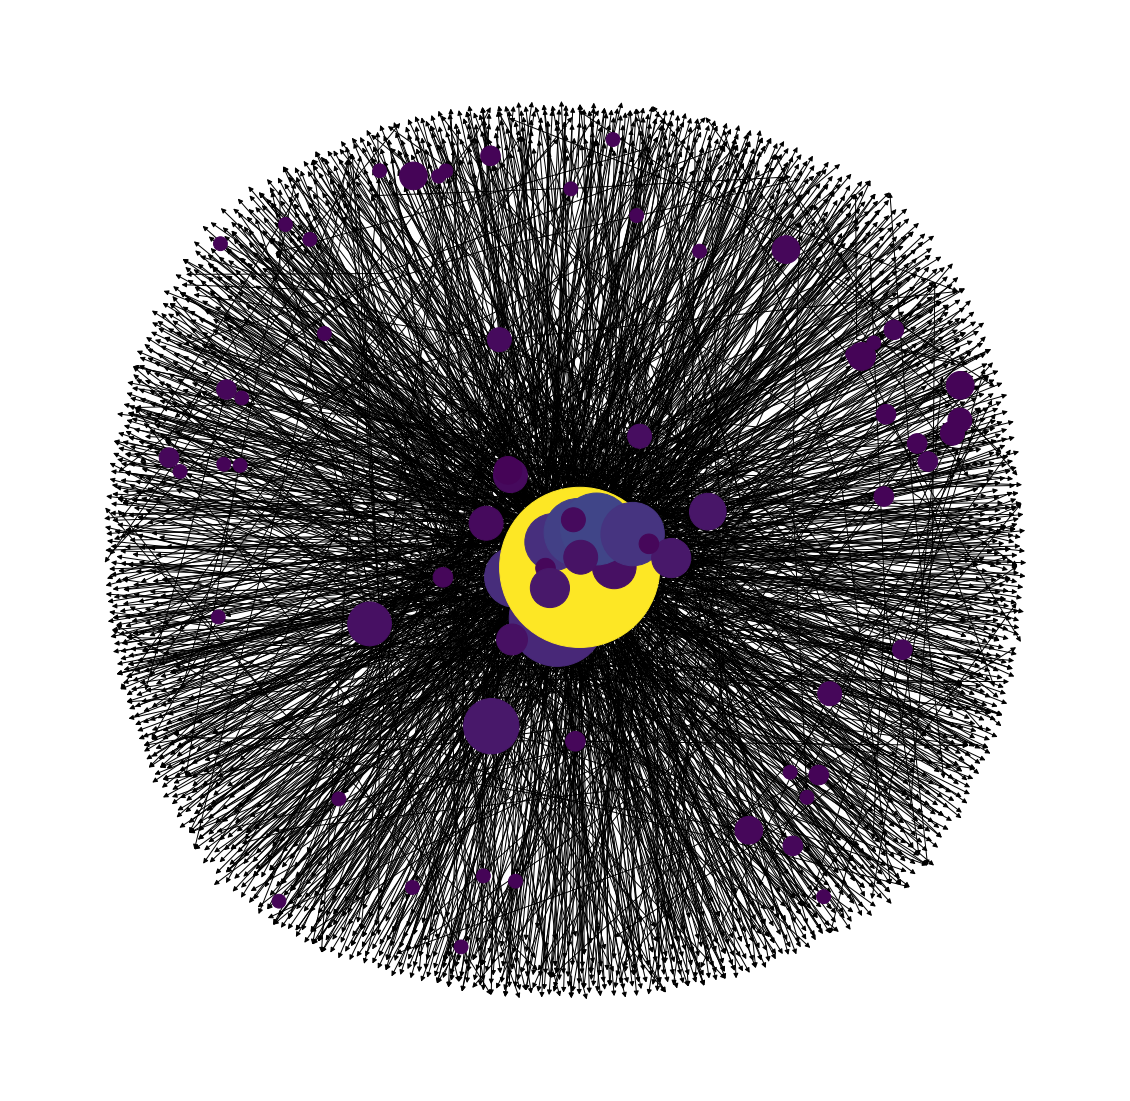

In [83]:
# Public citizen is most likely the yellow huge node
node_color = [200000000.0 * G_rt_full.out_degree(v) for v in G_rt_full]
node_size = [v * 1000000000 for v in cent_bet.values()]

plt.figure(figsize=(20,20))
nx.draw_networkx(G_rt_full, with_labels=False,node_color=node_color, node_size=node_size )

plt.axis('off')
plt.show()

## Bonus: Wordcloud

In [96]:
# Cleaning and joining retweets from FoxNews
all_text = [clean(doc) for doc in sotu_retweets_Fox['text']]
all_text = [strip_numeric(tweet) for tweet in all_text]
all_text = [strip_punctuation(tweet) for tweet in all_text]
all_text = [strip_multiple_whitespaces(tweet) for tweet in all_text]
all_text = [strip_short(tweet) for tweet in all_text]
all_text = [tweet.lower() for tweet in all_text]
all_text = " ".join(all_text)

In [97]:
type(all_text)

str

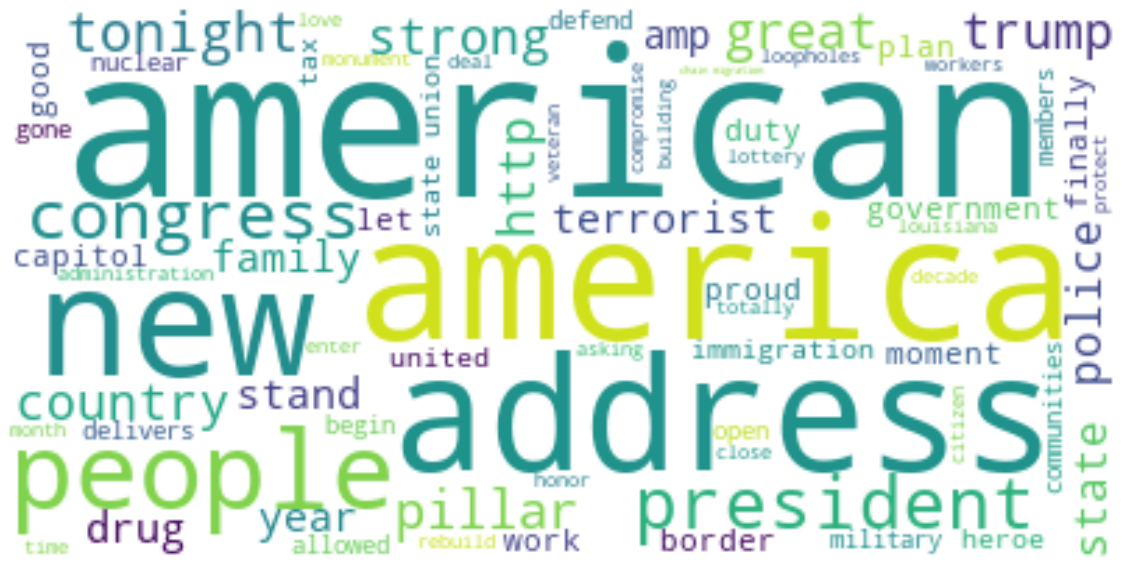

In [99]:
# Most common words
plt.figure(figsize=(20,20))

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color="white").generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Documentation retrieved from: https://networkx.github.io/documentation/stable/index.html